PRUEBA CON LOS PONDS

In [1]:
#cargamos la imágen
import imageio as imageio
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image 


In [2]:
im1 = imageio.imread('ponds.bmp')


C:\Users\Luciano-PC\AppData\Local\Temp\ipykernel_5648\429905463.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im1 = imageio.imread('ponds.bmp')


In [3]:
# Normalizar los valores de RGB del pixel: dividir los valores 0 a 255 por 255
#para obtener valores en el rango de 0 a 1. (no se usa)
def normalize_rgb(img):
    return np.clip(img /255.,0.,1.)

In [4]:
def lineal_a_tarzos(yiq,ymin,ymax):
    yiq[:, :, 0][yiq[:, :, 0] < ymin] = 0
    yiq[:, :, 0][yiq[:, :, 0] > ymax] = 1
    return yiq

In [5]:
#Chequear que Y’ <= 1 (para que no se vaya de rango)
#Chequear -0.5957 < I’ < 0.5957 y -0.5226 < Q’ < 0.5226
def check_yiq(yiq):
    yiq[:, :, 0] = np.clip(yiq[:, :, 0], 0, 1)  # Asegura que Y' esté en [0, 1]
    yiq[:, :, 1] = np.clip(yiq[:, :, 1], -0.5957, 0.5957)# Asegura que I' esté en [-0.5957, 0.5957]
    yiq[:, :, 2] = np.clip(yiq[:, :, 2], -0.5226, 0.5226)# Asegura que Q' esté en [-0.5226, 0.5226]
    return yiq

In [6]:
def RGB_to_YIQ(rgb):
    yiq = np.zeros(rgb.shape)
    yiq[:, :, 0] = 0.229 * rgb[:, :, 0] + 0.587 * rgb[:, :, 1] + 0.114 * rgb[:, :, 2]
    yiq[:, :, 1] = 0.595716 * rgb[:, :, 0] - 0.274453 * rgb[:, :, 1] - 0.321263 * rgb[:, :, 2]
    yiq[:, :, 2] = 0.211456 * rgb[:, :, 0] - 0.522591 * rgb[:, :, 1] + 0.311135 * rgb[:, :, 2]
    return yiq

In [7]:
def YIQ_to_RGB(yiq):
    rgb = np.zeros(yiq.shape)
    rgb[:, :, 0] = yiq[:, :, 0] + 0.9663 * yiq[:, :, 1] + 0.6210 * yiq[:, :, 2]
    rgb[:, :, 1] = yiq[:, :, 0] - 0.2721 * yiq[:, :, 1] - 0.6474 * yiq[:, :, 2]
    rgb[:, :, 2] = yiq[:, :, 0] - 1.1070 * yiq[:, :, 1] + 1.7046 * yiq[:, :, 2]
    return rgb

In [8]:
def mostrar_imagen_y_histograma(imagen, histograma, bins):
    # Crear una figura con dos subtramas
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Subtrama 1: Mostrar la imagen
    ax1.imshow(imagen)
    ax1.set_title("Imagen Normalizada")

    # Subtrama 2: Mostrar el histograma
    ax2.bar(bins[:-1], histograma, width=0.1, align='center', alpha=0.5)
    ax2.set_title("Histograma")
    ax2.set_xlabel("Valor de píxel normalizado")
    ax2.set_ylabel("Frecuencia")
    ax2.set_xticks(bins[:-1])
    ax2.grid(True)

    # Ajustar el espacio entre las subtramas
    plt.tight_layout()

    # Mostrar la figura
    plt.show()


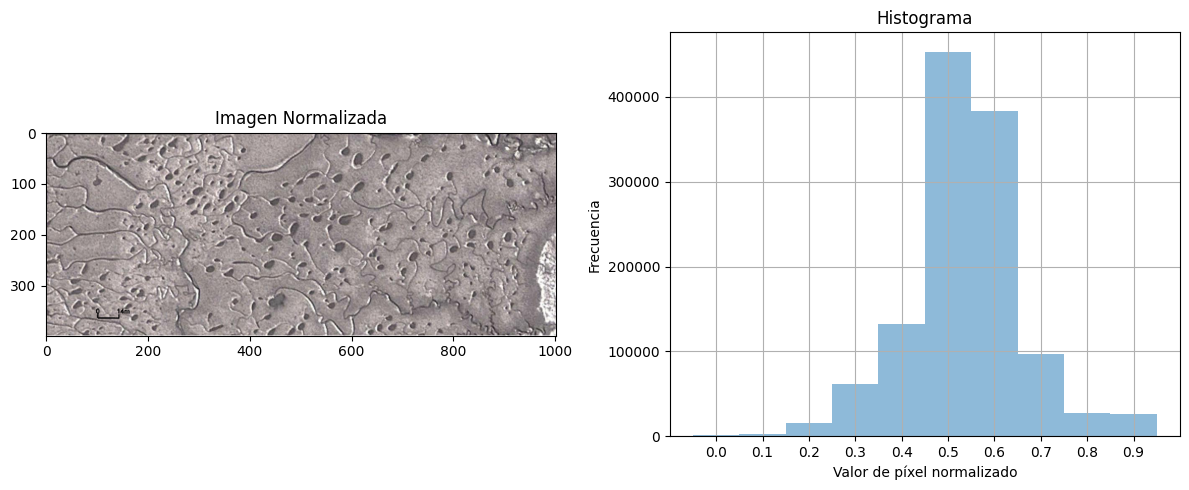

In [9]:
#VISUALIZAMOS IMAGEN ORIGINAL Y SU HISTOGRAMA
imagenNormalizada=normalize_rgb(im1)

# Genera un histograma con 10 columnas
histogram, bins = np.histogram(imagenNormalizada.flatten(), bins=10, range=(0, 1))

# Suponiendo que ya tienes 'imagenNormalizada' y 'histogram' definidos
mostrar_imagen_y_histograma(imagenNormalizada, histogram, bins)

## APLICACION LINEAL A TRAZOS

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


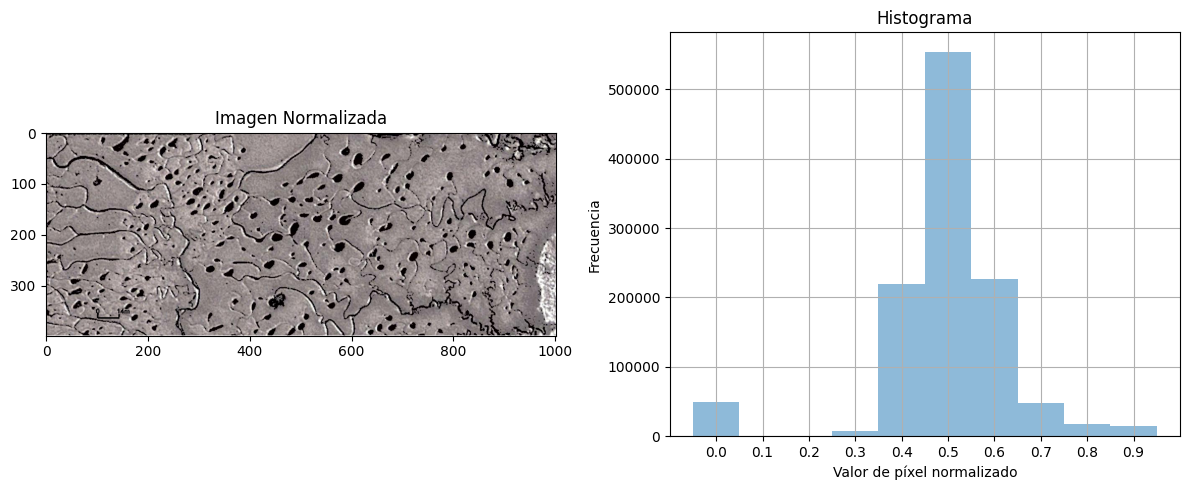

In [10]:
yiq = RGB_to_YIQ(imagenNormalizada)
imagen_binarizada= lineal_a_tarzos(yiq,0.40,0.90)
#imagen_binarizada= lineal_a_tarzos(yiq,0.43,0.67)
imagenProcesada=YIQ_to_RGB(imagen_binarizada)

# mostrar imagen procesada y visualizamos su histograma
histogram1, bins1 = np.histogram(imagenProcesada.flatten(), bins=10, range=(0, 1))
mostrar_imagen_y_histograma(imagenProcesada, histogram1, bins1)

## APLICACION CUADRATICA

In [11]:
def cuadratica(yiq):
    yiq[:, :, 0] = yiq[:, :, 0] * yiq[:, :, 0]
    return yiq

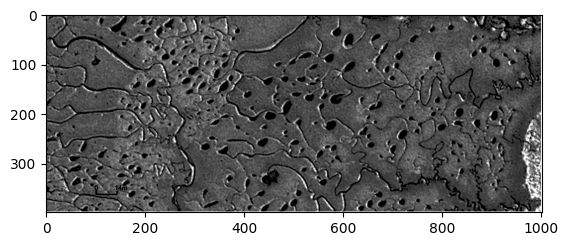

In [12]:
imagen_cuad = cuadratica(yiq)[:,:,0]
plt.imshow(imagen_cuad,'gray')
plt.show()

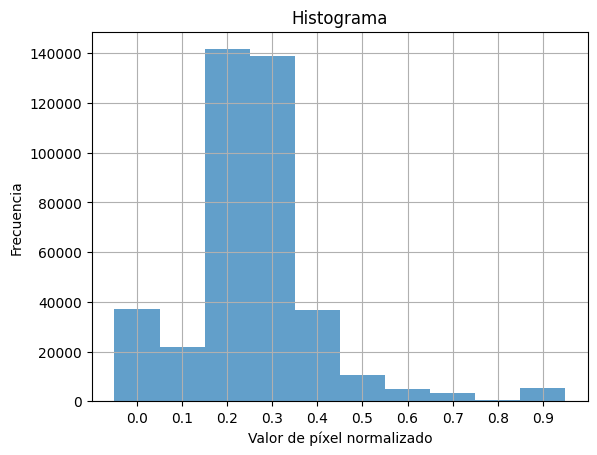

In [13]:
# Genera un histograma con 10 columnas
histogram, bins = np.histogram(imagen_cuad.flatten(), bins=10, range=(0, 1))

# Crear un gráfico de barras para el histograma
plt.bar(bins[:-1], histogram, width=0.1, align='center', alpha=0.7)
plt.title("Histograma")
plt.xlabel("Valor de píxel normalizado")
plt.ylabel("Frecuencia")
plt.xticks(bins[:-1])
plt.grid(True)
plt.show()

## APLICACION MEAN SHIFT

In [14]:
def mean_shift_yiq(image_yiq, window_size, max_iterations=100, convergence_threshold=1e-5):
    height, width, _ = image_yiq.shape

    # Inicializamos una copia de la imagen para almacenar el resultado
    result_yiq = np.copy(image_yiq)

    for y in range(height):
        for x in range(width):
            # Paso 1: Definimos la ventana alrededor del punto actual
            window_yiq = image_yiq[max(0, y - window_size):min(height, y + window_size),
                                   max(0, x - window_size):min(width, x + window_size)]

            # Paso 2: Calculamos la media ponderada
            while True:
                # Calculamos el centro de masa de la ventana
                weighted_sum = np.sum(window_yiq, axis=(0, 1))
                total_weight = window_yiq.size
                mean_yiq = weighted_sum / total_weight

                # Paso 3: Desplazamos la ventana al nuevo valor de la media
                new_window_yiq = image_yiq[max(0, y - window_size):min(height, y + window_size),
                                            max(0, x - window_size):min(width, x + window_size)]
                new_weighted_sum = np.sum(new_window_yiq, axis=(0, 1))
                new_total_weight = new_window_yiq.size
                new_mean_yiq = new_weighted_sum / new_total_weight

                # Verificamos la convergencia
                if np.linalg.norm(mean_yiq - new_mean_yiq) < convergence_threshold:
                    break

                # Actualizamos la ventana
                window_yiq = new_window_yiq

            # Asignamos el nuevo valor al píxel en la imagen de resultado
            result_yiq[y, x] = new_mean_yiq

    return result_yiq


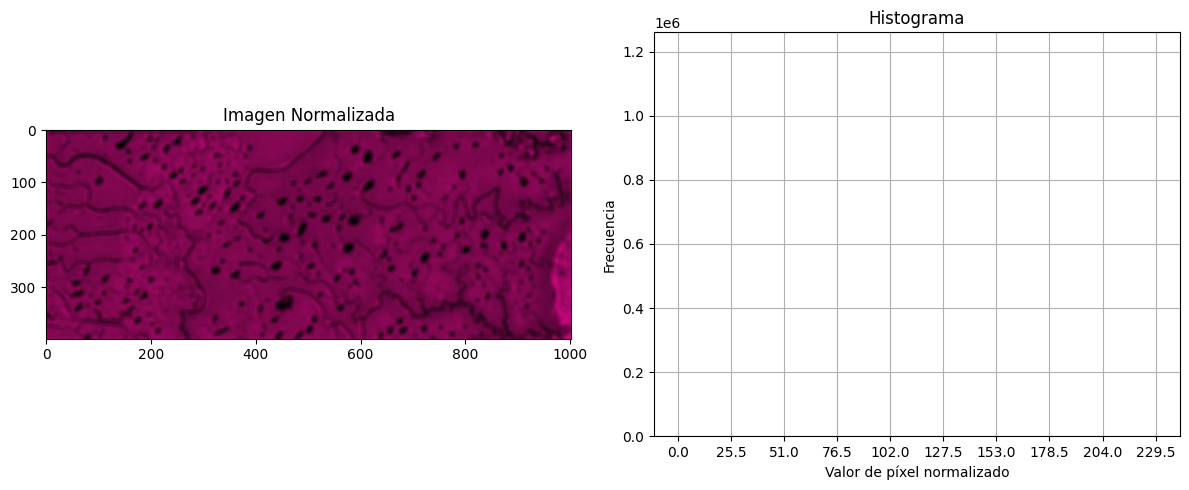

In [15]:
# Aplicar Mean Shift en el espacio de color YIQ
result_image_yiq = mean_shift_yiq(imagenProcesada, window_size=5)

# Convertir la imagen resultante de YIQ a RGB
result_image_rgb = YIQ_to_RGB(result_image_yiq)

# Mostrar la imagen procesada y su histograma
histogram1, bins1 = np.histogram(result_image_rgb.flatten(), bins=10, range=(0, 255))
mostrar_imagen_y_histograma(result_image_rgb, histogram1, bins1)

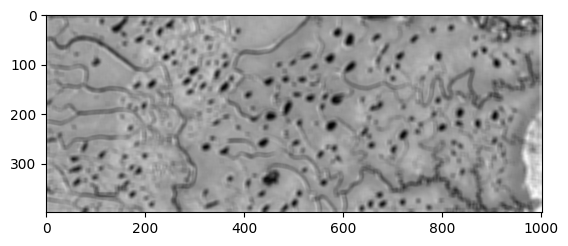

In [16]:
plt.imshow(result_image_yiq[:,:,0],'gray')
plt.show()

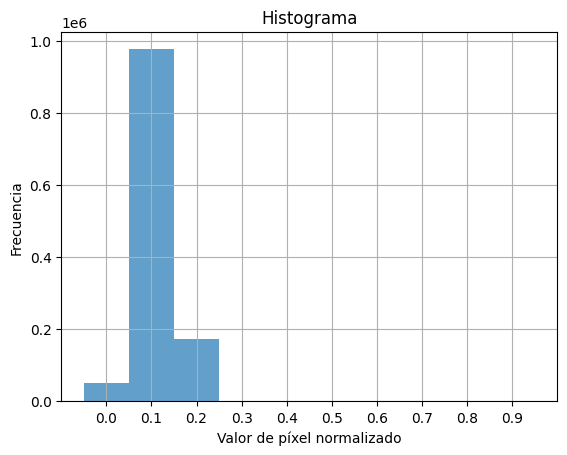

In [17]:
# Genera un histograma con 10 columnas
histogram, bins = np.histogram(result_image_yiq.flatten(), bins=10, range=(0, 1))

# Crear un gráfico de barras para el histograma
plt.bar(bins[:-1], histogram, width=0.1, align='center', alpha=0.7)
plt.title("Histograma")
plt.xlabel("Valor de píxel normalizado")
plt.ylabel("Frecuencia")
plt.xticks(bins[:-1])
plt.grid(True)
plt.show()

## APLICACION RAIZ

In [61]:
def raiz_cuadrada(yiq):
    yiq[:, :, 0] = np.sqrt(yiq[:, :, 0])
    return yiq


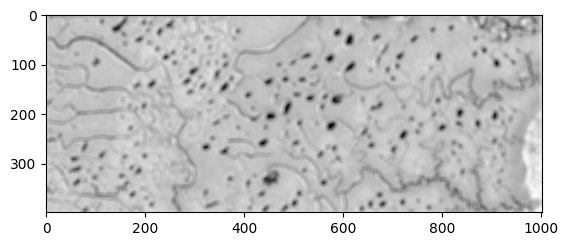

In [70]:
imagen_raiz = raiz_cuadrada(result_image_rgb)
plt.imshow(imagen_raiz[:, :, 0],'gray')
plt.show()

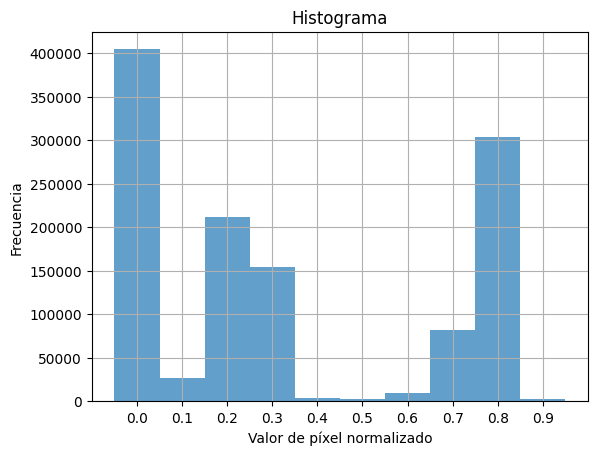

In [64]:
# Genera un histograma con 10 columnas
histogram, bins = np.histogram(imagen_raiz.flatten(), bins=10, range=(0, 1))

# Crear un gráfico de barras para el histograma
plt.bar(bins[:-1], histogram, width=0.1, align='center', alpha=0.7)
plt.title("Histograma")
plt.xlabel("Valor de píxel normalizado")
plt.ylabel("Frecuencia")
plt.xticks(bins[:-1])
plt.grid(True)
plt.show()